<a href="https://colab.research.google.com/github/Tandon-A/emotic/blob/master/Colab_train_emotic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Emotions in context (Emotic) </center></h1>
<center> Using context information to recognize emotions in images</center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>Project context</h1>

Humans use their facial features or expressions to convey how they feel, such as a person may smile when happy and scowl when angry. Historically, computer vision research has focussed on analyzing and learning these facial features to recognize emotions. 
However, these facial features are not universal and vary extensively across cultures and situations. 

<figure>
<img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/face.jpg"> <img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/full_scene.jpg" width="400">
  <figcaption>Fig 1: a) (Facial feature) The person looks angry or in pain b) (Whole scene) The person looks elated.</figcaption>
</figure>


A scene context, as shown in the figure above, can provide additional information about the situations. This project explores the use of context in recognizing emotions in images. 

This project uses the <a href="http://sunai.uoc.edu/emotic/download.html">EMOTIC dataset</a> and follows the methodology as introduced in the paper <a href="https://arxiv.org/pdf/2003.13401.pdf">'Context based emotion recognition using EMOTIC dataset'</a>.

In [ ]:
# Linking Google drive to use preprocessed data 
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Prepare places pretrained model

In [ ]:
# Get Resnet18 model trained on places dataset. 
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2022-03-30 05:03:39--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.195.26
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  11.8MB/s    in 5.6s    

2022-03-30 05:03:45 (7.74 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [ ]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. General imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model 

In [ ]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features, num_facial_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.num_facial_features = num_facial_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features+num_facial_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()

    
  def forward(self, x_context, x_body):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    facial_features=x_face.view(-1, self.num_facial_featires)
    fuse_features = torch.cat((context_features, body_features, facial_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)    
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face= self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [ ]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [ ]:
# Change data_src variable as per your drive
data_src = '/content/drive/My Drive/Emotic'


# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'emotic_pre','train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'emotic_pre','train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'emotic_pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'emotic_pre','train_cont_arr.npy'))

# Load validation preprocessed data 
val_context = np.load(os.path.join(data_src,'emotic_pre','val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'emotic_pre','val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'emotic_pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'emotic_pre','val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'emotic_pre','test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'emotic_pre','test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'emotic_pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'emotic_pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [ ]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(), 
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont, \
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. Prepare emotic model

In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)
model_face = models.resnet18(pretrained=True)

emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features, list(model_face.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))
model_face= nn.Sequential(*list(model_face.children()[:,-1]))

# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

completed cell


## Prepare optimizer

In [ ]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


# VI. Train model

In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  min_loss = np.inf

  train_loss = list()
  val_loss = list()

  model_context, model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)
    
    emotic_model.train()
    model_context.train()
    model_body.train()
    
    for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)

      pred_cat, pred_cont = emotic_model(pred_context, pred_body)
      cat_loss_batch = disc_loss(pred_cat, labels_cat)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
      running_loss += loss.item()
      loss.backward()
      opt.step()

    if e % 1 == 0: 
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)

    
    running_loss = 0.0 
    emotic_model.eval()
    model_context.eval()
    model_body.eval()
    
    with torch.no_grad():
      for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        
        pred_cat, pred_cont = emotic_model(pred_context, pred_body)
        cat_loss_batch = disc_loss(pred_cat, labels_cat)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
        running_loss += loss.item()

      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
      
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

  print ('completed training')
  
  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])

print ('completed cell')

completed cell


epoch = 0 training loss = 65069.5536
epoch = 0 validation loss = 6198.6410
saving model at epoch e = 0
epoch = 1 training loss = 47636.6416
epoch = 1 validation loss = 5955.0975
saving model at epoch e = 1
epoch = 2 training loss = 45794.4474
epoch = 2 validation loss = 5964.9087
epoch = 3 training loss = 44478.9837
epoch = 3 validation loss = 5591.3248
saving model at epoch e = 3
epoch = 4 training loss = 43479.7044
epoch = 4 validation loss = 5693.9630
epoch = 5 training loss = 42913.9699
epoch = 5 validation loss = 5657.3477
epoch = 6 training loss = 42615.8510
epoch = 6 validation loss = 5717.3125
epoch = 7 training loss = 41733.1875
epoch = 7 validation loss = 5550.4043
saving model at epoch e = 7
epoch = 8 training loss = 41502.6519
epoch = 8 validation loss = 5502.7081
saving model at epoch e = 8
epoch = 9 training loss = 41415.5390
epoch = 9 validation loss = 5575.6067
epoch = 10 training loss = 41248.2311
epoch = 10 validation loss = 5564.8765
epoch = 11 training loss = 41100.

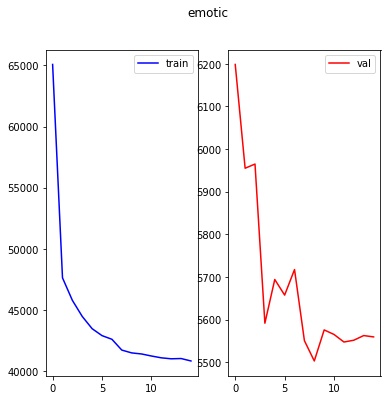

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

# VII. Test model

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [ ]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10 
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (ap_mean, vad_mean)
    return ap_mean, vad_mean 

print ('completed cell')

completed cell


In [ ]:
model_context = torch.load('./models/model_context1.pth')
model_body = torch.load('./models/model_body1.pth')
emotic_model = torch.load('./models/model_emotic1.pth')

print ('completed cell')

completed cell


In [ ]:
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())

print ('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %(val_ap, val_vad))
print ('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %(test_ap, test_vad))

starting testing
completed testing
ap [0.38256893 0.19466378 0.21762462 0.9488687  0.17395075 0.7872753
 0.238573   0.3689456  0.19346166 0.2100256  0.05997106 0.9793508
 0.2524582  0.7964124  0.14025436 0.07741655 0.80626005 0.17314902
 0.27596825 0.4995427  0.21144335 0.08669689 0.19484593 0.15506798
 0.34908342 0.1157445 ] (26,) 0.34190857
vad [0.7119999  0.85126567 0.8607694 ] (3,) 0.8080117
0.34190857 0.8080117
starting testing
completed testing
ap [0.28431448 0.08905081 0.14205858 0.56508815 0.06810296 0.75600785
 0.12755705 0.23106177 0.16030155 0.16969804 0.02750396 0.86425656
 0.15542151 0.6942229  0.09294637 0.05966878 0.6598641  0.06903157
 0.21856393 0.4207046  0.18510231 0.06621439 0.18708271 0.09078831
 0.1357776  0.07295728] (26,) 0.25359032
vad [0.8947723 1.0272166 0.9424933] (3,) 0.95482737
0.25359032 0.95482737
validation Mean average precision=0.3419 Mean VAD MAE=0.8080
testing Mean average precision=0.2536 Mean VAD MAE=0.9548


In [ ]:
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']
print (cat_preds.shape, cat_labels.shape)

#thesholds calculation for inference 
thresholds = get_thresholds(cat_preds, cat_labels)
print (thresholds, thresholds.shape)

print ('completed cell')

(26, 7203) (26, 7203)
[0.10622907 0.31307584 0.16624811 0.17563866 0.23123509 0.1305049
 0.21684988 0.11014247 0.07814439 0.08188582 0.11858815 0.4828021
 0.07789605 0.14657235 0.11349562 0.12154831 0.21958952 0.26292533
 0.10428832 0.10117985 0.17581657 0.14261195 0.24182932 0.098947
 0.09637145 0.08739559] (26,)
completed cell


# VIII. Average Precision computation using <a href="https://1drv.ms/u/s!AkYHbdGNmIVCgbYZB_dY3wuWJou_5A?e=jcsZUj">author's script</a>

In [ ]:
!apt install octave

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aglfn epstool fonts-droid-fallback fonts-noto-mono ghostscript gnuplot-data
  gnuplot-qt gsfonts imagemagick-6-common info install-info libamd2
  libauthen-sasl-perl libcamd2 libccolamd2 libcholmod3 libcolamd2
  libcupsfilters1 libcupsimage2 libcxsparse3 libdata-dump-perl libemf1
  libencode-locale-perl libfftw3-single3 libfile-listing-perl libfltk-gl1.3
  libfltk1.3 libfont-afm-perl libgail-common libgail18 libglpk40
  libgraphicsmagick++-q16-12 libgraphicsmagick-q16-3 libgs9 libgs9-common
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libijs-0.35 libio-html-perl
  libio-socket-ssl-perl libjbig2dec0 liblqr-1-0 liblua5.3-0
  liblwp-mediat

In [ ]:
%%writefile eval.m

gt = load('./cat_labels.mat')
gt = gt.cat_labels

pred = load('./cat_preds.mat')
pred = pred.cat_preds

categories{1} = 'Affection';
categories{2} = 'Anger';
categories{3} = 'Annoyance';
categories{4} = 'Anticipation';
categories{5} = 'Aversion';
categories{6} = 'Confidence';
categories{7} = 'Disapproval';
categories{8} = 'Disconnection';
categories{9} = 'Disquietment';
categories{10} = 'Doubt/Confusion';
categories{11} = 'Embarrassment';
categories{12} = 'Engagement';
categories{13} = 'Esteem';
categories{14} = 'Excitement';
categories{15} = 'Fatigue';
categories{16} = 'Fear';
categories{17} = 'Happiness';
categories{18} = 'Pain';
categories{19} = 'Peace';
categories{20} = 'Pleasure';
categories{21} = 'Sadness';
categories{22} = 'Sensitivity';
categories{23} = 'Suffering';
categories{24} = 'Surprise';
categories{25} = 'Sympathy';
categories{26} = 'Yearning';


for c = 1:length(categories)
  confidence = pred(c,:)'; 
  testClass = gt(c,:)';
  confidence = double(confidence);

  S = rand('state');
  rand('state',0);
  confidence = confidence + rand(size(confidence))*10^(-10);
  rand('state',S)

  [S,j] = sort(-confidence);
  C = testClass(j);
  n = length(C);
    
  REL = sum(C);
  if n>0
    RETREL = cumsum(C);
    RET    = (1:n)';
  else
    RETREL = 0;
    RET    = 1;
  end

  precision = 100*RETREL ./ RET;
  recall    = 100*RETREL  / REL;
  th = -S;

  % compute AP
  mrec=[0 ; recall ; 100];
  mpre=[0 ; precision ; 0];
  for i=numel(mpre)-1:-1:1
    mpre(i)=max(mpre(i),mpre(i+1));
  end
  i=find(mrec(2:end)~=mrec(1:end-1))+1;
  averagePrecision=sum((mrec(i)-mrec(i-1)).*mpre(i))/100;
  ap_list(c)  = averagePrecision
end

display('#######################################')

display('Average precision of predictions');
for c = 1:length(categories)
    sp = '............................';
    cat = strcat(categories{c}, sp);
    cat = cat(1:18);
    display(cat);
    display(ap_list(c));
end

Writing eval.m


In [ ]:
!octave -W eval.m

Streaming output truncated to the last 5000 lines.
   9.3272e-02   4.7889e-02   2.1647e-02   2.7097e-02   8.8336e-02   1.1079e-01
   2.4899e-02   5.0537e-02   9.0297e-02   3.3718e-02   6.7336e-03   1.4732e-01
   1.8850e-02   6.8631e-02   4.9326e-02   3.5029e-03   2.5862e-02   1.5477e-01
   1.9628e-02   2.9701e-02   6.1501e-02   3.8620e-02   1.1058e-02   1.2406e-01
   5.0518e-01   6.1875e-01   4.9541e-01   6.3503e-01   5.9971e-01   4.9264e-01
   7.0011e-02   5.3344e-02   9.0196e-02   4.1759e-02   3.3116e-02   6.1454e-02
   1.5904e-01   1.1061e-01   2.8906e-01   3.5345e-01   8.9594e-02   2.5393e-02
   3.4500e-02   2.4334e-02   3.1402e-02   3.1966e-02   5.5980e-02   1.1979e-01
   3.4343e-02   4.6420e-02   6.0500e-02   4.1948e-02   8.1668e-03   1.0831e-01
   2.5949e-01   1.3865e-01   2.6279e-01   7.3784e-02   2.0740e-01   1.5805e-01
   2.0541e-02   1.8222e-02   5.7839e-02   2.6544e-02  -9.0343e-03   1.0769e-01
   5.5246e-02   5.0229e-02   2.8835e-02  -3.1811e-04   7.8460e-02   8.3877e-02
 